In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo
from sklearn.model_selection import train_test_split
import os.path
import keras
import numpy as np
from matplotlib import pyplot as plt
import OPT_helper
from sklearn.model_selection import train_test_split
np.random.seed(432)
X=np.vstack([np.random.multivariate_normal([-5,2], [[2,5],[5,1]], 2000),
             np.random.multivariate_normal([0,8], [[2,-3],[-3,2]], 2000)])
y=np.hstack([np.ones(2000),
             np.zeros(2000)])
#X=df[['Peso','Altura']].values
#y=df['Genero'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

Using TensorFlow backend.
/home/cselmo/.conda/envs/doctorado-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  if sys.path[0] == '':
/home/cselmo/.conda/envs/doctorado-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  del sys.path[0]


<Figure size 640x480 with 1 Axes>

In [312]:
y_test

array([0, 1, 1, ..., 1, 1, 0])

# RMSProp y Adadelta

## RMSProp

- RMSProp y Adadelta son extensiones de Adagrad que buscan mitigar el efecto de acumular indefinidamente el cuadrado de los gradientes.
- En vez de acumular indefinidamente el cuadrado de los gradientes, propone una regla de actualización que atenúa la contribución del gradiente en cada instante a medida que pasa el tiempo.
- Para lograr esto de manera automática, Adadelta propone lo siguiente:

$$ E[g^2]_t=\gamma  E[g^2]_{t-1} + (1-\gamma)g^2_t $$

- $E[g^2]_t$ juega el mismo papel que $G(k)$ en ambos algoritmos. Utilizamos $E[g^2]$ para respetar la notación del paper.
- $\gamma$ es una constante que vale entre 0 y 1.
- al actualizar $E[g^2]$ con un valor menor que uno, el efecto de los $g^2$ muy viejos desaparece.

Veamos un ejemplo:

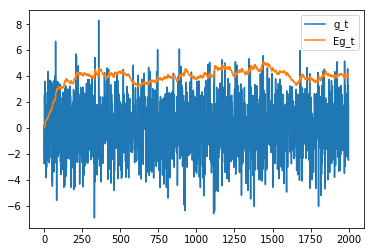

In [31]:
# Probar con gamma 0.1,0.5,0.9 y 0.95
g_t=np.zeros(2000)
g_t=np.random.normal(loc=0,scale=2,size=2000)
Eg_t=np.zeros(2000)
#g_t[0]=1
g_t[50]=1
gamma=0.99
Eg_t[0]=(1-gamma)*g_t[0]**2
for idx in range(len(Eg_t)-1):
    Eg_t[idx+1]=gamma*Eg_t[idx]+(1-gamma)*g_t[idx]**2
plt.plot(g_t,label="g_t")
plt.plot(Eg_t,label="Eg_t")
plt.legend()
plt.show()

- Como se ve, $Eg_t$ converge a la varianza de g_t, para ciertos valores específicos de $\gamma$
- Utilizando $Eg_t$ para actualizar el learning rate, nos queda: 

$$\eta_t=\frac{\eta_{base}}{\sqrt{E[g^2_t] + \epsilon}}$$

Lo cual nos da un learning rate distinto para cada uno de los parámetros, pero en vez de estar pesado por la raíz cuadrada de la energía (suma de los cuadrados) de los gradientes, está pesado por la raíz cuadrada de la potencia (suma de los cuadrados por unidad de tiempo).
A la raíz cuadrada de la potencia se la conoce como RMS (root mean square). Por lo tanto nos queda:

$$RMS[g]_t=\sqrt{E[g^2_t] + \epsilon}$$

$$\eta_t=\frac{\eta_{base}}{RMS[g]_t}$$
$$\Delta \vec W_t=-\frac{\eta}{RMS[g]_t}*g_t$$

A esta última regla de actualización se la conoce como **RMSProp**. No hay un paper publicado al respecto, pero figura en las notas de clase de Hinton. Los valores que recomienda son $\gamma=0.9$ y $\eta_{base}=0.001$.
En definitiva, RMSProp equivale a normalizar el gradiente en t por la raíz cuadrada de la potencia de los gradientes.

## Adadelta

Adadelta tiene una modificación mas. Inspirado en el método de Newton, en vez de utilizar el gradiente y multiplicarlo por el $\eta$, utiliza $RMS[\Delta \vec W]_t$ como learning rate. De esta forma los saltos en $\vec W$ quedan normalizados por la raíz de la potencia de dichas modificaciones.

La regla nos queda:

$$\Delta \vec W_t=-\frac{RMS[\Delta \vec W]_{t-1}}{RMS[g]_t} \cdotp g_t$$

Al igual que $RMS[g]_t$, $RMS[\Delta \vec W]_{t-1}$ se obtiene de manera recursiva:

$$ E[\Delta \vec W^2]_t=\gamma  E[\Delta \vec W^2]_{t-1} + (1-\gamma)\Delta \vec W^2_t $$

La última ecuación deja claro por qué se utiliza  $RMS[\Delta \vec W]_{t-1}$ y no  $RMS[\Delta \vec W]_{t}$ para el cálculo de $\Delta \vec W_t$.

El algoritmo Adadelta no necesita un learning rate definido. Los valores de $\gamma$ oscilan típicamente entre 0.9 y 0.99.

# Red Neuronal de 1 capa

In [2]:
# Esta función recibe un modelo y devuelve los pesos que se quieren loggear
def get_weights(model):
    weights=list()
    for layer in model.layers[0:]:
        weights.append([layer.get_weights()[1][0],layer.get_weights()[0][0][0],layer.get_weights()[0][1][0]])
    return weights
def set_weights(model,w0,w1,w2):
    weights=model.layers[0].get_weights()
    weights[0][0][0]=w1
    weights[0][1][0]=w2
    weights[1][0]=w0
    model.layers[0].set_weights(weights)
def reset_weights(model):
    weights=model.layers[-1].get_weights()
    weights[0][0]=weights[0][0]*0
    model.layers[-1].set_weights(weights)


Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.020000000298023225.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.003999999910593033.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.
Restoring model weights from the end of the best epoch

Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.00015999998431652786.


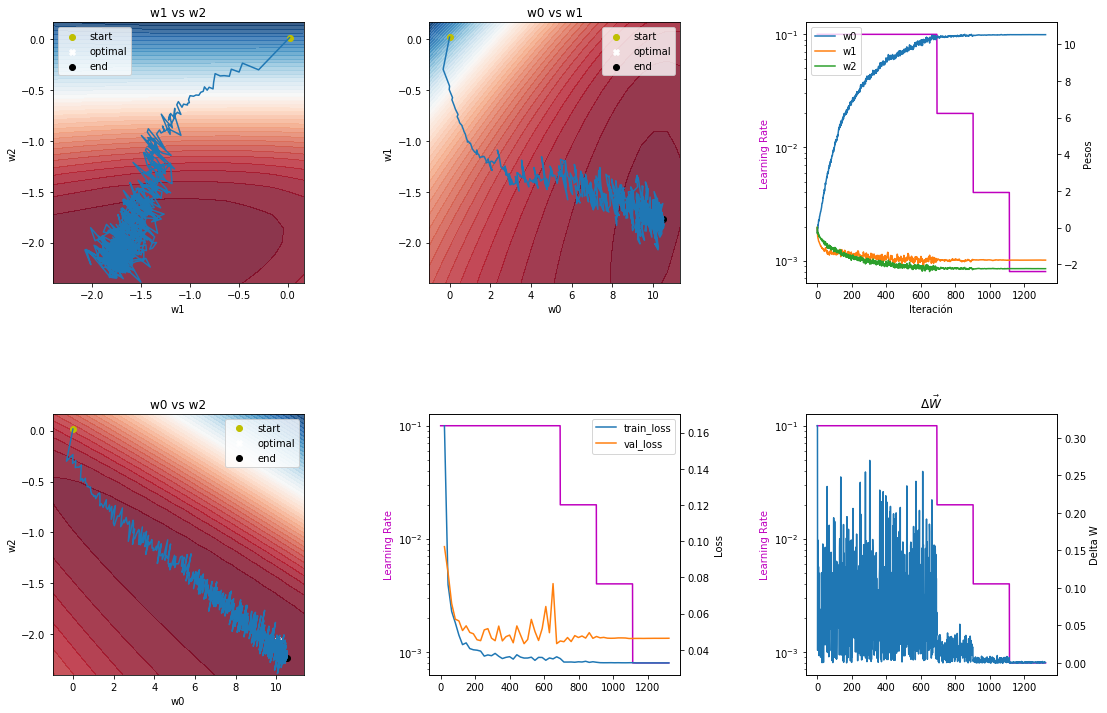

Epoch 00063: early stopping


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:],activation='sigmoid', kernel_initializer='normal', name='salida'))
optimizer = optimizers.RMSprop(lr=0.1,
                               epsilon=1e-8, 
                               decay=0.0)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer)
earlyStopping=EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=40, verbose=1, restore_best_weights=True)
reduceLR=ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2, 
                           patience=10, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)
logWeights=OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.767115,
                                  w2_opt=-2.05875,
                                  w0_opt=10.087935,
                                  plotloss_data=(x_train, y_train))

history=model.fit(x_train, 
          y_train ,
          epochs=200,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping, reduceLR])


Epoch 00071: ReduceLROnPlateau reducing learning rate to 12.0.

Epoch 00081: ReduceLROnPlateau reducing learning rate to 7.199999999999999.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 4.319999885559082.
Restoring model weights from the end of the best epoch

Epoch 00101: ReduceLROnPlateau reducing learning rate to 2.591999816894531.


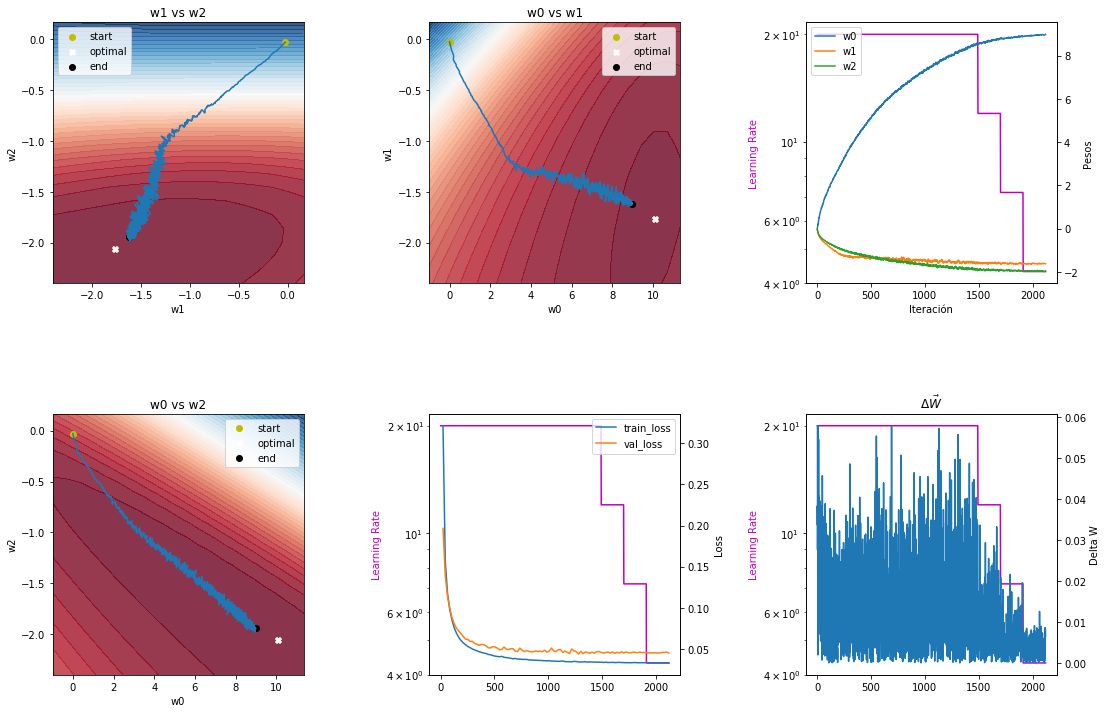

Epoch 00101: early stopping


In [6]:
## Adadelta
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:],activation='sigmoid', kernel_initializer='normal', name='salida'))
optimizer = optimizers.Adadelta(lr=20)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer)
earlyStopping=EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=40, verbose=1, restore_best_weights=True)
reduceLR=ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.6, 
                           patience=10, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)
logWeights=OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.767115,
                                  w2_opt=-2.05875,
                                  w0_opt=10.087935,
                                  plotloss_data=(x_train, y_train))

history=model.fit(x_train, 
          y_train ,
          epochs=200,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping, reduceLR])